In [1]:
import os
import sys
import pandas as pd
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic1"):
    os.chdir("..")
    print(f"Changed to {os.getcwd()}")
from codebase import get_total_inhabitants_and_willingness

Changed to C:\Users\david\PycharmProjects\TUE\Design-of-AI-driven-business-operation
Loaded file from Excel and saved to CSV


In [2]:
within_mins = 50
punt = "highschool" # ibis, hbo_wo, mbo, basis, highschool, bus, trein
mode = "ebike" # fiets, ebike
location = "Education" # Elementary Schools, High Schools, Universities, Train - NS, Train - Local

total, total_willing = get_total_inhabitants_and_willingness(punt1=punt, mode=mode, within_mins=within_mins, location=location, verbose=True)

Loaded file from Excel and saved to CSV
Demographics and filtered dataframes do not match in length: 14296 vs 14297, ignoring missing values
Total inhabitants within 50 minutes of highschool from buurt: 17745810 of 17811291 = 99.63% of the Netherlands
Total willingness to cycle of those: 15445679 of 17745810 = 87.04%


In [3]:
#open gpkg file: "C:\Users\david\PycharmProjects\TUE\Design-of-AI-driven-business-operation\data\02_punt_tot_punt_analyse\trainstations.gpkg"
import geopandas as gpd
gdf = gpd.read_file("data/02_punt_tot_punt_analyse/trainstations.gpkg")
print(gdf.columns)
#find specific stations 187, 297, 190, 443, 459, 185, 382, 528, 186, 189])


print(gdf[gdf["train_id"] == 186])



Index(['train_id', 'name', 'fe_code', 'type', 'geometry'], dtype='object')
     train_id              name fe_code       type  \
331       186  Amsterdam Amstel     Asa  intercity   

                          geometry  
331  POINT (123013.292 484409.811)  


In [4]:
# ----- DATA LADEN -----
from codebase.load_data.load_demographics import load_demograhics
from codebase.load_data.load_buurt import load_buurt_data
df_demo = load_demograhics()
df_rail = load_buurt_data("trein", mode="ebike")      # O-D naar stations

# ----- PER BUURT SLECHTS 1 RIJ (kortste reistijd) -----
df_rail_nearest = (
    df_rail
    .sort_values("reistijd_min")          # kleinste eerst
    .drop_duplicates("bu_code", keep="first")
)

# ----- MERGE & RESULTATEN -----
merged = df_rail_nearest.merge(
    df_demo[["gwb_code", "a_inw"]],
    left_on="bu_code",
    right_on="gwb_code",
    how="inner",
    validate="one_to_one"                 # nu wél uniek
)

# populatie-gewogen detour
pw_detour = (
    merged["omrijdfactor"]                 # detour
    .rename_axis(merged["bu_code"])        # index = bu_code
)
print(pw_detour.nlargest(10))


Loaded file from Excel and saved to CSV


ValueError: Use `.rename` to alter labels with a mapper.

In [20]:
def safe_merge_multi(punt_df, demo_df,
                     pop_col="a_inw",
                     punt_col="bu_code",
                     demo_col="gwb_code"):
    punt = punt_df.copy()
    demo = demo_df[[demo_col, pop_col]].copy()
    punt[punt_col] = punt[punt_col].astype(str)
    demo[demo_col] = demo[demo_col].astype(str)

    return punt.merge(
        demo,
        left_on=punt_col,
        right_on=demo_col,
        how="inner",
        validate="many_to_one"  # links mogen dubbelen, rechts niet
    )


In [5]:
merged = safe_merge_multi(df_rail, df_demo)
# bijvoorbeeld: inwoners met detour > 1.3
cond = merged["omrijdfactor"] > 1.3
high_detour_pop = merged.loc[cond].groupby("bu_code")["a_inw"].sum()
print(high_detour_pop.head())


NameError: name 'safe_merge_multi' is not defined

In [6]:
import pandas as pd
from codebase.load_data.load_demographics import load_demograhics
from codebase.load_data.load_buurt import load_buurt_data

# ----------------------------------------------------------------------
# 0. Helper: many-to-one merge (buurt kan meerdere OD-rijen hebben)
# ----------------------------------------------------------------------

def safe_merge_multi(punt_df: pd.DataFrame,
                     demo_df: pd.DataFrame,
                     punt_col="bu_code",
                     demo_col="gwb_code",
                     pop_col="a_inw") -> pd.DataFrame:

    keep = [demo_col, pop_col, "gm_naam"]          # hier extra kolommen toevoegen
    demo = demo_df[keep].copy()
    punt = punt_df.copy()

    punt[punt_col] = punt[punt_col].astype(str)
    demo[demo_col] = demo[demo_col].astype(str)

    return punt.merge(
        demo,
        left_on=punt_col,
        right_on=demo_col,
        how="inner",
        validate="many_to_one"
    )

# ----------------------------------------------------------------------
# 1. Dataset laden (voorbeeld: e-bike → railstations)
# ----------------------------------------------------------------------
df_demo = load_demograhics()                         # bevat o.a. kolom a_inw
df_rail = load_buurt_data("trein", mode="ebike")     # bevat reistijd_min, afstand_hemelsbreed_m, omrijdfactor

df = safe_merge_multi(df_rail, df_demo)              # heeft nu ook a_inw

# ----------------------------------------------------------------------
# 2. Vraag 1 – populatie-gewogen detour per buurt
# ----------------------------------------------------------------------
tmp = (df["omrijdfactor"] * df["a_inw"]).groupby(df["bu_code"]).sum()
pop = df.groupby("bu_code")["a_inw"].sum()
pw_detour = (tmp / pop).rename("pw_detour")          # Series
print(pw_detour.nlargest(20))                        # top-20 buurten

# ----------------------------------------------------------------------
# 3. Vraag 2 – inwoners per gemeente met detour > 1.3
# ----------------------------------------------------------------------
cond = df["omrijdfactor"] > 1.3
high_detour_pop = df.loc[cond].groupby("gm_naam")["a_inw"].sum()
print(high_detour_pop.sort_values(ascending=False).head())

# ----------------------------------------------------------------------
# 4. Vraag 3 – ‘verborgen verliezers’ (≤30 min crow-fly, >30 min netwerk)
# ----------------------------------------------------------------------
df["t_crowfly_min"] = df["afstand_hemelsbreed_m"] / (25000 / 60)   # 25 km/h e-bike
mask_hidden = (df["t_crowfly_min"] <= 30) & (df["reistijd_min"] > 30)
hidden_pop = df.loc[mask_hidden].groupby("bu_code")["a_inw"].sum()
print(hidden_pop.head())

# ----------------------------------------------------------------------
# 5. Vraag 4 – buurten met hoge detour én hoge trip-dichtheid
# ----------------------------------------------------------------------
trip_cnt   = df.groupby("bu_code").size().rename("trip_cnt")
summary    = pd.concat([pw_detour, trip_cnt], axis=1).dropna()
q_detour   = summary["pw_detour"].quantile(0.8)      # bovenste 20 %
q_trips    = summary["trip_cnt"].quantile(0.8)
candidates = summary[(summary["pw_detour"] > q_detour) & (summary["trip_cnt"] > q_trips)]
print(candidates.sort_values("pw_detour", ascending=False).head())

# ----------------------------------------------------------------------
# 6. Vraag 5 – scenario: detour >1.2 verlagen naar 1.15, bereik 30 min
# ----------------------------------------------------------------------
df["detour_adj"] = df["omrijdfactor"].where(df["omrijdfactor"] <= 1.2, 1.15)
df["t_new"]      = df["reistijd_min"] / df["omrijdfactor"] * df["detour_adj"]
reachable_new    = df[df["t_new"] <= 30].groupby("gm_naam")["a_inw"].sum()
print(reachable_new.sort_values(ascending=False).head())


Loaded file from Excel and saved to CSV
bu_code
BU06770402    5.730000
BU06770401    5.555000
BU06771502    5.410000
BU06770602    5.157500
BU06770403    5.147500
BU06771503    5.015000
BU06771501    4.952500
BU06771301    4.680000
BU06771302    4.600000
BU06770902    4.588333
BU06770601    4.445000
BU06770801    4.411250
BU06770803    4.405000
BU06770104    4.317500
BU06770802    4.285000
BU06770103    4.272500
BU06770105    4.260000
BU06770805    4.211250
BU06770303    4.195000
BU06770804    4.186250
Name: pw_detour, dtype: float64
gm_naam
Almere       5854530
Amsterdam    4549835
Zaanstad     2108865
Rotterdam    1956035
Dordrecht    1201165
Name: a_inw, dtype: int64
bu_code
BU00140000     8810
BU00140001    13140
BU00140002     8320
BU00140003     1700
BU00140004       20
Name: a_inw, dtype: int64
            pw_detour  trip_cnt
bu_code                        
BU08520201   1.560758        66
BU08520200   1.535606        66
BU0363NQ08   1.489474        76
BU0363BA02   1.474921      

In [7]:
import geopandas as gpd

# Pad naar jouw GeoPackage
gdf = gpd.read_file("data/WijkBuurtkaart_2023_v2\wijkenbuurten_2023_v2.gpkg")


# Bekijk kolomnamen
print(gdf.columns)

# Merge met jouw detour-waarden
map_pw = gdf.merge(pw_detour, left_on="buurtcode", right_index=True)

# Sla op als GeoPackage voor gebruik in GIS / QGIS
map_pw.to_file("pw_detour.gpkg", layer="pw_detour", driver="GPKG")

<>:4: SyntaxWarning: invalid escape sequence '\w'
<>:4: SyntaxWarning: invalid escape sequence '\w'
C:\Users\david\AppData\Local\Temp\ipykernel_30656\2313164923.py:4: SyntaxWarning: invalid escape sequence '\w'
  gdf = gpd.read_file("data/WijkBuurtkaart_2023_v2\wijkenbuurten_2023_v2.gpkg")
C:\Users\david\PycharmProjects\1bm110_data_driven_AI\.venv\Lib\site-packages\pyogrio\geopandas.py:265: UserWarning: More than one layer found in 'wijkenbuurten_2023_v2.gpkg': 'buurten' (default), 'gemeenten', 'wijken'. Specify layer parameter to avoid this warning.
  result = read_func(


Index(['buurtcode', 'buurtnaam', 'wijkcode', 'gemeentecode', 'gemeentenaam',
       'indelingswijziging_wijken_en_buurten', 'water',
       'meest_voorkomende_postcode', 'dekkingspercentage',
       'omgevingsadressendichtheid',
       ...
       'afstand_tot_open_nat_natuurlijk_terrein',
       'afstand_tot_semiopenbaar_groen_totaal', 'afstand_tot_sportterrein',
       'afstand_tot_volkstuin', 'afstand_tot_verblijfsrecreatief_terrein',
       'afstand_tot_recreatief_binnenwater', 'afstand_tot_begraafplaats',
       'jrstatcode', 'jaar', 'geometry'],
      dtype='object', length=224)


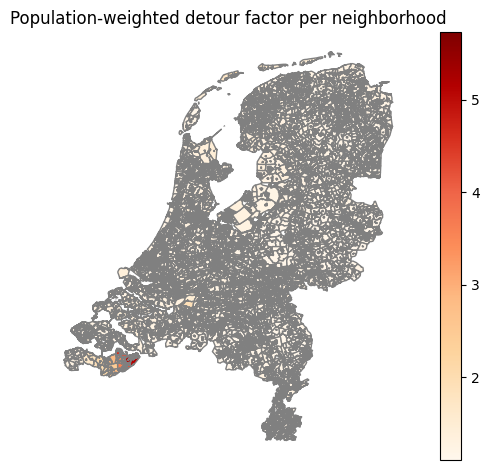

In [8]:
import matplotlib.pyplot as plt

map_pw.plot(column="pw_detour", cmap="OrRd", legend=True, edgecolor="grey")
plt.title("Population-weighted detour factor per neighborhood")

plt.axis("off")
plt.tight_layout()
plt.savefig("pw_detour_map.png", dpi=1000)
plt.show()


In [9]:
import json
import numpy as np

def willingness_to_cycle(tij, location, mode="fiets", param_path=None):
    """
    Calculate the willingness to cycle based on travel time and location.

    Args:
        tij (float, array): Travel time in minutes.
        location (str): Location code.
        mode (str): One of "fiets" or "ebike. Default is "fiets".
    """
    if param_path is None:
        param_path = f"data/cycle_willingness/{mode}.json"

    with open(param_path, "r") as f:
        model_params = json.load(f)

    if location not in model_params:
        raise ValueError("Unknown location")

    a, b = model_params[location]
    F_ij = 1 / (1 + np.exp(a + b * np.log(tij + 1e-10)))

    return F_ij

In [10]:
from codebase.load_data.load_demographics import load_demograhics
from codebase.load_data.load_buurt        import load_buurt_data


# ------------------------------------------------------------------------
# A. Load & merge once, reuse everywhere
df_demo = load_demograhics()                         # CBS table (incl. a_inw, gm_naam …)
df_punt = load_buurt_data("trein", mode=MODE)        # O-D to rail stations (incl. reistijd_min …)

# If the column with station id is called something else, fix it here:
df_punt = df_punt.rename(columns={"station_id_column_in_file": "dest_station_id"})

# Add crow-fly travel time (needed for ‘hidden_mask’ later)
# 25 km/h assumed for e-bike → 25000 m per h ≈ (25000/60)m per min
df_punt["t_crowfly_min"] = df_punt["afstand_hemelsbreed_m"] / (25000/60)

# Merge demographics (many-to-one) – the helper you already used

df = safe_merge_multi(df_punt, df_demo)
# ------------------------------------------------------------------------


Loaded file from Excel and saved to CSV


NameError: name 'MODE' is not defined

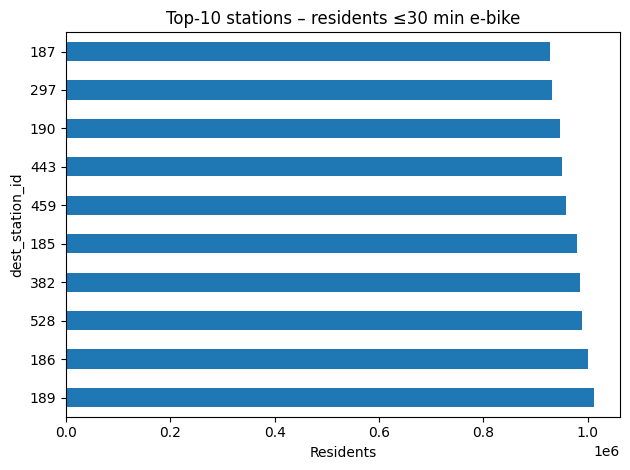

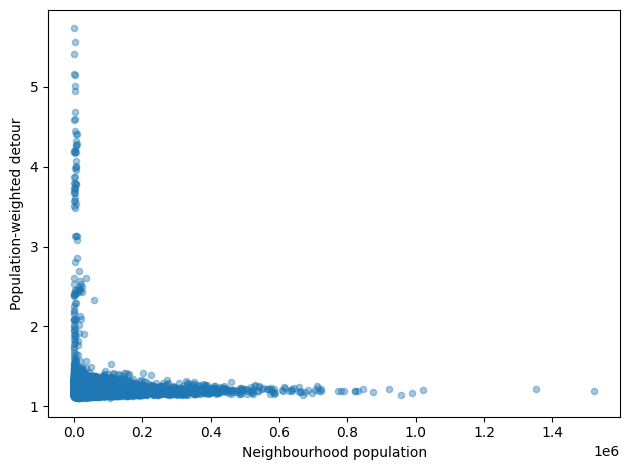

C:\Users\david\PycharmProjects\1bm110_data_driven_AI\.venv\Lib\site-packages\pyogrio\geopandas.py:265: UserWarning: More than one layer found in 'wijkenbuurten_2023_v2.gpkg': 'buurten' (default), 'gemeenten', 'wijken'. Specify layer parameter to avoid this warning.
  result = read_func(


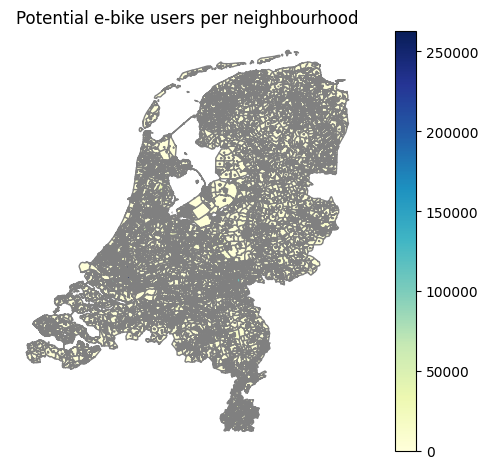

QC: NL population totals roughly match (after dedup)


In [11]:
# -----------------------------  CONFIG  ---------------------------------
OUTDIR   = "results"                       # all CSV/figures end up here
LOCATION = "Education"                     # valid key in ebike.json
MODE     = "ebike"                         # "fiets" or "ebike"
GPKG     = "data/WijkBuurtkaart_2023_v2/wijkenbuurten_2023_v2.gpkg"
# ------------------------------------------------------------------------

import os, pandas as pd, matplotlib.pyplot as plt, geopandas as gpd


os.makedirs(OUTDIR, exist_ok=True)

# ------------------------------------------------------------------------
# 0.  COLUMN ALIASES  (make sure we do not duplicate)
# ------------------------------------------------------------------------
if "dest_station_id" not in df.columns and "train_id" in df.columns:
    df = df.rename(columns={"train_id"     : "dest_station_id"})
if "t_ebike_min"   not in df.columns and "reistijd_min" in df.columns:
    df = df.rename(columns={"reistijd_min" : "t_ebike_min"})

df = df.loc[:, ~df.columns.duplicated()]     # drop accidental dups
# ------------------------------------------------------------------------



# ========== 2. ACCESSIBILITY INDICATORS (≤30 min e-bike) ================
within30   = df[df["t_ebike_min"] <= 30]
pop_in_30  = within30.groupby("dest_station_id")["a_inw"].sum()
share_30   = pop_in_30 / df_demo["a_inw"].sum()     # national total
tbl_access = pd.concat([pop_in_30, share_30.rename("share_30")], axis=1)
tbl_access.to_csv(f"{OUTDIR}/station_pop30.csv")

# ========== 3. WILLINGNESS TRANSLATION  =================================
df["p_time"]    = willingness_to_cycle(df["t_ebike_min"],
                                       location=LOCATION, mode=MODE)
df["potential"] = df["a_inw"] * df["p_time"]

pot_sta  = df.groupby("dest_station_id")["potential"].sum()
pot_buur = df.groupby("bu_code")["potential"].sum()
pot_sta.to_csv (f"{OUTDIR}/station_potential_users.csv")
pot_buur.to_csv(f"{OUTDIR}/buurt_potential_users.csv")

# ========== 4. NETWORK-EFFICIENCY FLAGS  ===============================
mean_det = (df["omrijdfactor"] * df["a_inw"]).groupby(df["bu_code"]).sum() \
           / df.groupby("bu_code")["a_inw"].sum()

hidden_mask = (df["t_crowfly_min"] <= 30) & (df["t_ebike_min"] > 30)
hidden_pop  = df.loc[hidden_mask].groupby("bu_code")["a_inw"].sum()
hidden_pop[hidden_pop > 0].to_csv(f"{OUTDIR}/hidden_losers.csv")

# ========== 5. KPI-MATRIX PER GEMEENTE =================================
kpi = df.groupby("gm_naam").agg(
        pop_in_30 = ('a_inw',
                     lambda s, df=df: s[df.loc[s.index, "t_ebike_min"] <= 30].sum()),
        potential = ('potential', 'sum'),
        mean_det  = ('omrijdfactor',
                     lambda s, df=df: (s * df.loc[s.index, "a_inw"]).sum()
                                      / df.loc[s.index, "a_inw"].sum())
)
kpi.to_csv(f"{OUTDIR}/kpi_gemeente.csv")

#Focus on gemeente with highest mean_det and most inhabitants

# ========== 5a. KPI-MATRIX PER BUURT ==================================


# ========== 6. BASIC VISUALS  ==========================================
# 6a Bar chart – top-10 stations by reachable pop
top10 = tbl_access.nlargest(10, "a_inw")
top10["a_inw"].plot(kind="barh")
plt.title("Top-10 stations – residents ≤30 min e-bike")
plt.xlabel("Residents")
plt.tight_layout()
plt.savefig(f"{OUTDIR}/bar_top10_stations.png", dpi=300)
plt.show()


# 6b Scatter – neighbourhood pop vs. mean detour
scatter_df = mean_det.to_frame("mean_det").merge(
    df.groupby("bu_code")["a_inw"].sum(), left_index=True, right_index=True
)
scatter_df.plot.scatter(x="a_inw", y="mean_det", alpha=0.4)
plt.xlabel("Neighbourhood population")
plt.ylabel("Population-weighted detour")
plt.tight_layout()
plt.savefig(f"{OUTDIR}/scatter_pop_vs_detour.png", dpi=300)
plt.show()


# 6c Choropleth – potential users
gdf = gpd.read_file(GPKG)[["buurtcode", "geometry"]]
gdf = gdf.merge(pot_buur.rename("potential"), left_on="buurtcode", right_index=True)
gdf.plot(column="potential", cmap="YlGnBu", legend=True, edgecolor="grey")
plt.title("Potential e-bike users per neighbourhood")
plt.axis("off")
plt.tight_layout()
plt.savefig(f"{OUTDIR}/map_potential_users.png", dpi=300)
plt.show()


# ========== 7. (optional) PCA etc. =====================================
# ... leave False unless you actually want it ...

# ========== 8. VALIDATION  =============================================
# ---------------- QC: correcte bevolkings-teller -----------------
# haal uitsluitend de nationale totaalrij ('NL00')
pop_cbs = df_demo.loc[df_demo["gwb_code"] == "NL00", "a_inw"].iloc[0]

pop_df   = df[["bu_code", "a_inw"]].drop_duplicates()
pop_fact = pop_df["a_inw"].sum()

assert abs(pop_fact - pop_cbs) / 1e6 < 0.1, \
       f"Pop mismatch {abs(pop_fact-pop_cbs):,.0f}"
print("QC: NL population totals roughly match (after dedup)")




In [41]:
#focus with highest mean_det
kpi.sort_values("mean_det", ascending=False, inplace=True)

#highest highest mean_det with most inhabitants
print(kpi.nlargest(10, "mean_det"))


                    pop_in_30      potential  mean_det
gm_naam                                               
Hulst                       0      54.165980  4.019760
Terneuzen                   0     219.847969  2.358002
Terschelling                0       0.236252  1.806423
Ameland                     0       5.722796  1.588582
Schiermonnikoog             0       2.443958  1.472109
Vlieland                    0       0.053167  1.394190
Edam-Volendam          101630  147988.379178  1.374695
Goeree-Overflakkee          0   14328.258998  1.371011
Schouwen-Duiveland          0    9314.868290  1.368425
Waterland               39385   88444.455906  1.366939


In [38]:
print(df.columns.tolist())


['train_id', 'bu_code', 'reistijd_min', 'reisafstand_m', 'afstand_hemelsbreed_m', 'omrijdfactor', 't_crowfly_min', 'gwb_code', 'a_inw', 'gm_naam']


In [39]:
import json

with open("data/cycle_willingness/ebike.json") as f:
    params = json.load(f)

print(list(params.keys()))


['Work', 'Shop', 'Education', 'Recreation', 'Tour', 'Urban_1', 'Urban_2', 'Urban_3', 'Urban_4', 'Urban_5']


In [50]:
import os
print(os.listdir())  # toont bestanden in je huidige map




['.git', '.gitattributes', '.gitignore', '.idea', 'codebase', 'data', 'graphics', 'high_detour_pct.csv', 'pw_detour.gpkg', 'pw_detour_map.png', 'requirements.txt', 'results', 'test.py', 'Topic1', 'Topic2', 'Topic3']
